### Import libraries

In [1]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing, sentiment, ner, language detection
import re
import nltk
from textblob import TextBlob
import spacy
from langdetect import detect
import collections
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


# Import the word cloud function   
from wordcloud import WordCloud, STOPWORDS

## Vectorisation, for bag-of-words, feature selection
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn import feature_selection


## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load the dataset and read with pandas dataframe

In [2]:
tra = pd.read_csv('indiana_reports.csv')
tra.head(2)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.


### Data Preparation and Exploratory Data Analysis (EDA)

##### Create another dataframe (txt) with "Problems" as label and "findings" as text, and rename as 'y' and 'text'

In [3]:
#txt[txt['findings'].isna()]
txt = tra[['Problems', 'findings']]
txt = txt.rename(columns={"Problems":"y", "findings":"text"})
txt.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
1,Cardiomegaly;Pulmonary Artery,Borderline cardiomegaly. Midline sternotomy XX...
2,normal,NaN
3,"Pulmonary Disease, Chronic Obstructive;Bullous...",There are diffuse bilateral interstitial and a...
4,Osteophyte;Thickening;Lung,The cardiomediastinal silhouette and pulmonary...


### Filtered the label categories to select only 9 class.

In [4]:
## filter categories   ##'Pulmonary Atelectasis','Implanted Medical Device', 'Foreign Bodies', 'Atherosclerosis', 
txt = txt[txt["y"].isin(['Calcified Granuloma','Calcinosis','Opacity','Cardiomegaly','Spondylosis',
                         'Granulomatous Disease', 'Osteophyte', 'Fractures, Bone', 'normal', 
                         'Surgical Instruments'])][["y","text"]]
txt.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
2,normal,NaN
5,normal,Heart size and mediastinal contour are within ...
7,normal,"The heart, pulmonary XXXX and mediastinum are ..."
9,Calcified Granuloma,The cardiomediastinal silhouette is within nor...


### Remove the rows whose columns have missing values (NaN) 

In [5]:
text_df = txt[pd.notnull(txt['text'])].reset_index()
text_df.head()

,index,y,text
0,0,normal,The cardiac silhouette and mediastinum size ar...
1,5,normal,Heart size and mediastinal contour are within ...
2,7,normal,"The heart, pulmonary XXXX and mediastinum are ..."
3,9,Calcified Granuloma,The cardiomediastinal silhouette is within nor...
4,10,normal,Cardiomediastinal silhouette and pulmonary vas...


### Drop the idex column

In [6]:
dtf = text_df.iloc[: , 1:]
dtf.head()

,y,text
0,normal,The cardiac silhouette and mediastinum size ar...
1,normal,Heart size and mediastinal contour are within ...
2,normal,"The heart, pulmonary XXXX and mediastinum are ..."
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...
4,normal,Cardiomediastinal silhouette and pulmonary vas...


### Check the shape of the data

##### There are 1423 entries and 2 features

In [7]:
print(dtf.shape)
dtf.columns.values

(1442, 2)


array(['y', 'text'], dtype=object)

### data info

##### The dataframe has two (2) columns both are categorical and 1442 entries (row)
##### No missing values (NaN has been removed)

In [8]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       1442 non-null   object
 1   text    1442 non-null   object
dtypes: object(2)
memory usage: 22.7+ KB


### Label class with their value counts

In [9]:
dtf.y.unique()

array(['normal', 'Calcified Granuloma', 'Granulomatous Disease',
       'Spondylosis', 'Surgical Instruments', 'Opacity', 'Osteophyte',
       'Calcinosis', 'Fractures, Bone', 'Cardiomegaly'], dtype=object)

In [10]:
dtf.y.value_counts()

normal                   1197
Calcified Granuloma        72
Calcinosis                 33
Opacity                    28
Cardiomegaly               24
Spondylosis                20
Surgical Instruments       19
Granulomatous Disease      18
Fractures, Bone            16
Osteophyte                 15
Name: y, dtype: int64

### Univariate distribution of the target showing labels frequency with a bar plots.

<AxesSubplot:xlabel='y', ylabel='count'>

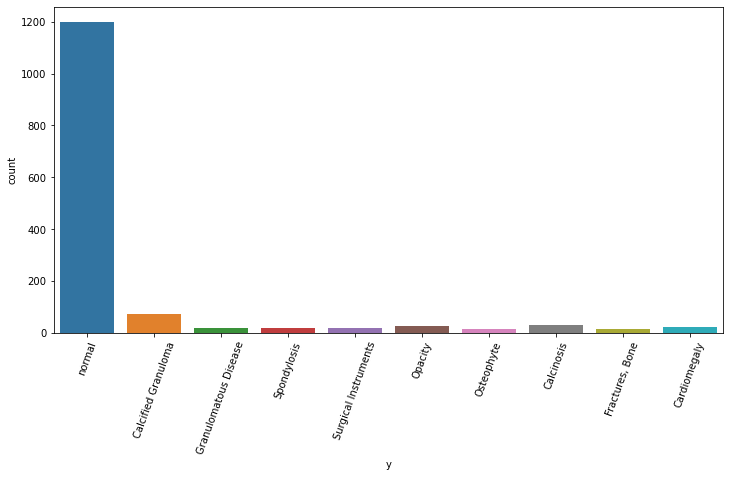

In [11]:
plt.figure(figsize=(12,6))
plt.xticks(rotation= 70)
sns.countplot(x='y',data=dtf)

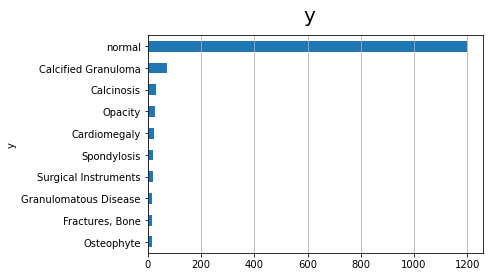

In [12]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize= 20)
dtf["y"].reset_index().groupby("y").count().sort_values(by="index").plot(kind="barh", 
                                                                                  legend=False,
                                                                         ax=ax).grid(axis='x')
plt.show()

##### It could be deduced from the dataframe that there is data imbalance with normal accounted for over 50% of the observation.

### Word visualisation 

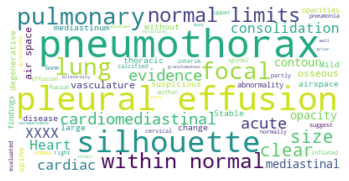

In [13]:
s = pd.Series(dtf.text[0:10], dtype="string")

# Concatenating a single Series into a string
t=s.str.cat(sep=',')

# Create and generate a word cloud image 
my_cloud =  WordCloud(background_color='white', stopwords=STOPWORDS).generate(t)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
# Don't forget to show the final image
plt.show()

### Named-Entity Recognition

##### Tag named entities mentioned in unstructured text with pre-defined categories such as person names, organizations, locations, time expressions, quantities,

In [14]:
## call model
ner = spacy.load("en_ner_bionlp13cg_md")

## tag text
txt = dtf["text"].iloc[0]
doc = ner(txt)

## display result
spacy.displacy.render(doc, style="ent")

##### Run the NER model on every text observation in the dataset

In [15]:
## tag text and exctract tags into a list
dtf["tags"] = dtf["text"].apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents] )
dtf["tags"]

0       [(cardiac, ORGAN), (mediastinum, MULTI_TISSUE_...
1       [(Heart, ORGAN), (focal airspace, CELLULAR_COM...
2       [(heart, ORGAN), (pulmonary, ORGAN), (mediasti...
3       [(lungs, ORGAN), (focal airspace, CELLULAR_COM...
4       [(pulmonary vasculature, MULTI_TISSUE_STRUCTUR...
                              ...                        
1437    [(lungs, ORGAN), (pleural, ORGAN), (heart, ORG...
1438    [(heart, ORGAN), (focal airspace, CELLULAR_COM...
1439    [(pleural, MULTI_TISSUE_STRUCTURE), (airspace,...
1440    [(vasculature, MULTI_TISSUE_STRUCTURE), (lungs...
1441                   [(cardiac, ORGAN), (lungs, ORGAN)]
Name: tags, Length: 1442, dtype: object

##### Create a new column for each tag category

In [16]:
## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
dtf["tags"] = dtf["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in dtf["tags"].tolist():
     for dic in lst:
        for k in dic.keys():
            tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     dtf["tags_"+feature] = dtf["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))

## print result
dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,tags_CANCER,tags_IMMATERIAL_ANATOMICAL_ENTITY,tags_ORGAN,tags_TISSUE,tags_MULTI_TISSUE_STRUCTURE,tags_ANATOMICAL_SYSTEM,tags_ORGANISM
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,0,0,2,0,1,0,0
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,0,0,4,0,0,0,0
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,0,0,4,0,1,0,0
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,0,0,3,1,0,0,0
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,0,0,1,0,1,0,0


##### Plot the most frequent tags for the "Cardiomegaly" headline categories

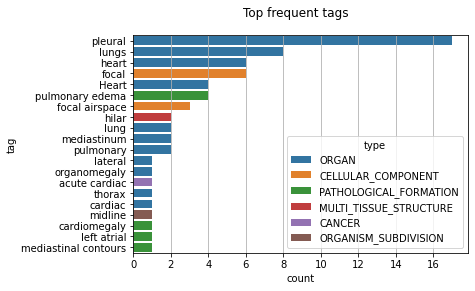

In [17]:
y = "Cardiomegaly"
tags_list = dtf[dtf["y"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:20,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

### Language detection

In [18]:
txt = dtf["text"].iloc[0]
print(txt, " --> ", detect(txt))

The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.  -->  en


In [19]:
#dtf['lang'] = dtf["text"].apply(lambda x: detect(x) if x.strip() != "" else "")

def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

dtf['Lang'] = dtf['text'].apply(det)

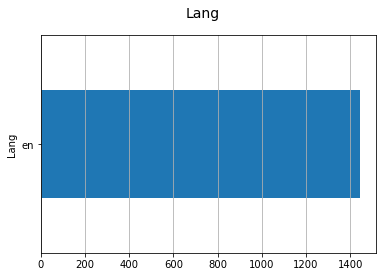

In [20]:
#plt.rcParams['figure.figsize'] = [10, 8]
#plt.rcParams['figure.dpi'] = 70

x = 'Lang'
fig, ax = plt.subplots()
fig.suptitle(x, fontsize= 14)
dtf[x].reset_index().groupby(x).count().sort_values(by= "index").plot(kind="barh",
                                                                      legend=False, ax=ax).grid(axis='x')
#plt.yticks(rotation = 0)
plt.show()

##### NER is applied to prevent some words like name from being lost e.g "Will" in Will Smith, when stopwords are removed. Though not likely to present inour dataset (Not applicable for this dataset)

In [21]:
## predict wit NER

txt = dtf["text"].iloc[100]
entities = ner(txt).ents
## tag text
tagged_txt = txt
for tag in entities:
    tagged_txt = re.sub(tag.text, "_".join(tag.text.split()), 
                        tagged_txt) 
## show result
print(tagged_txt)

The cardiomediastinal silhouette is normal size and configuration. Pulmonary_vasculature within normal limits. The lungs are well-aerated. There is no pneumothorax, pleural effusion, or focal consolidation.


### Text preprocessing

##### Cleaning text, removing stop words, tokenisation, and applying lemmatization.

In [22]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [23]:
lst_stopwords = nltk.corpus.stopwords.words("english")
#lst_stopwords

In [24]:
txt = dtf["text"].iloc[0]

print("--- original ---")
print(txt)
print("--- cleaning ---")
txt = re.sub(r'[^\w\s]', '', str(txt).lower().strip())
print(txt)
print("--- tokenization ---")
txt = txt.split()
print(txt)

--- original ---
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.
--- cleaning ---
the cardiac silhouette and mediastinum size are within normal limits there is no pulmonary edema there is no focal consolidation there are no xxxx of a pleural effusion there is no evidence of pneumothorax
--- tokenization ---
['the', 'cardiac', 'silhouette', 'and', 'mediastinum', 'size', 'are', 'within', 'normal', 'limits', 'there', 'is', 'no', 'pulmonary', 'edema', 'there', 'is', 'no', 'focal', 'consolidation', 'there', 'are', 'no', 'xxxx', 'of', 'a', 'pleural', 'effusion', 'there', 'is', 'no', 'evidence', 'of', 'pneumothorax']


In [25]:
print("--- remove stopwords ---")
txt = [word for word in txt if word not in lst_stopwords]
print(txt)

--- remove stopwords ---
['cardiac', 'silhouette', 'mediastinum', 'size', 'within', 'normal', 'limits', 'pulmonary', 'edema', 'focal', 'consolidation', 'xxxx', 'pleural', 'effusion', 'evidence', 'pneumothorax']


In [26]:
print("--- stemming ---")
ps = nltk.stem.porter.PorterStemmer()
print([ps.stem(word) for word in txt])
print("--- lemmatisation ---")
lem = nltk.stem.wordnet.WordNetLemmatizer()
print([lem.lemmatize(word) for word in txt])

--- stemming ---
['cardiac', 'silhouett', 'mediastinum', 'size', 'within', 'normal', 'limit', 'pulmonari', 'edema', 'focal', 'consolid', 'xxxx', 'pleural', 'effus', 'evid', 'pneumothorax']
--- lemmatisation ---
['cardiac', 'silhouette', 'mediastinum', 'size', 'within', 'normal', 'limit', 'pulmonary', 'edema', 'focal', 'consolidation', 'xxxx', 'pleural', 'effusion', 'evidence', 'pneumothorax']


In [27]:
dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
                                                                      lst_stopwords=lst_stopwords))
dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,tags_CANCER,tags_IMMATERIAL_ANATOMICAL_ENTITY,tags_ORGAN,tags_TISSUE,tags_MULTI_TISSUE_STRUCTURE,tags_ANATOMICAL_SYSTEM,tags_ORGANISM,Lang,text_clean
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,0,0,2,0,1,0,0,en,cardiac silhouette mediastinum size within nor...
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,0,0,4,0,0,0,0,en,heart size mediastinal contour within normal l...
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,0,0,4,0,1,0,0,en,heart pulmonary xxxx mediastinum within normal...
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,0,0,3,1,0,0,0,en,cardiomediastinal silhouette within normal lim...
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,0,0,1,0,1,0,0,en,cardiomediastinal silhouette pulmonary vascula...


In [28]:
print(dtf["text"].iloc[0], " --> ", dtf["text_clean"].iloc[0])

The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.  -->  cardiac silhouette mediastinum size within normal limit pulmonary edema focal consolidation xxxx pleural effusion evidence pneumothorax


### Length Analysis

##### word count: counts the number of tokens in the text separated by space
##### character count: sum number of the characters of each token
##### sentence count: counts number of sentences separated by a period
##### average word length: character count/word count
##### average sentence length: word cont/sentence count

In [29]:
dtf['word_count'] = dtf["text"].apply(lambda x: len(str(x).split(" ")))

dtf['char_count'] = dtf["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

dtf['sentence_count'] = dtf["text"].apply(lambda x: len(str(x).split(".")))

dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']

dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']

dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,...,tags_MULTI_TISSUE_STRUCTURE,tags_ANATOMICAL_SYSTEM,tags_ORGANISM,Lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,...,1,0,0,en,cardiac silhouette mediastinum size within nor...,34,177,6,5.205882,5.666667
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,0,0,0,en,heart size mediastinal contour within normal l...,32,194,5,6.062500,6.400000
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,...,1,0,0,en,heart pulmonary xxxx mediastinum within normal...,38,202,5,5.315789,7.600000
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,0,0,0,en,cardiomediastinal silhouette within normal lim...,38,236,6,6.210526,6.333333
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,...,1,0,0,en,cardiomediastinal silhouette pulmonary vascula...,21,141,5,6.714286,4.200000


In [30]:
display(dtf.iloc[45])

y                                                                  Calcified Granuloma
text                                 Stable postsurgical changes. Heart XXXX, media...
tags                                 [{('Heart', 'ORGAN'): 1}, {('mediastinum', 'MU...
tags_AMINO_ACID                                                                      0
tags_GENE_OR_GENE_PRODUCT                                                            0
tags_ORGANISM_SUBSTANCE                                                              0
tags_CELL                                                                            0
tags_CELLULAR_COMPONENT                                                              0
tags_PATHOLOGICAL_FORMATION                                                          0
tags_ORGANISM_SUBDIVISION                                                            0
tags_CANCER                                                                          0
tags_IMMATERIAL_ANATOMICAL_ENTITY          

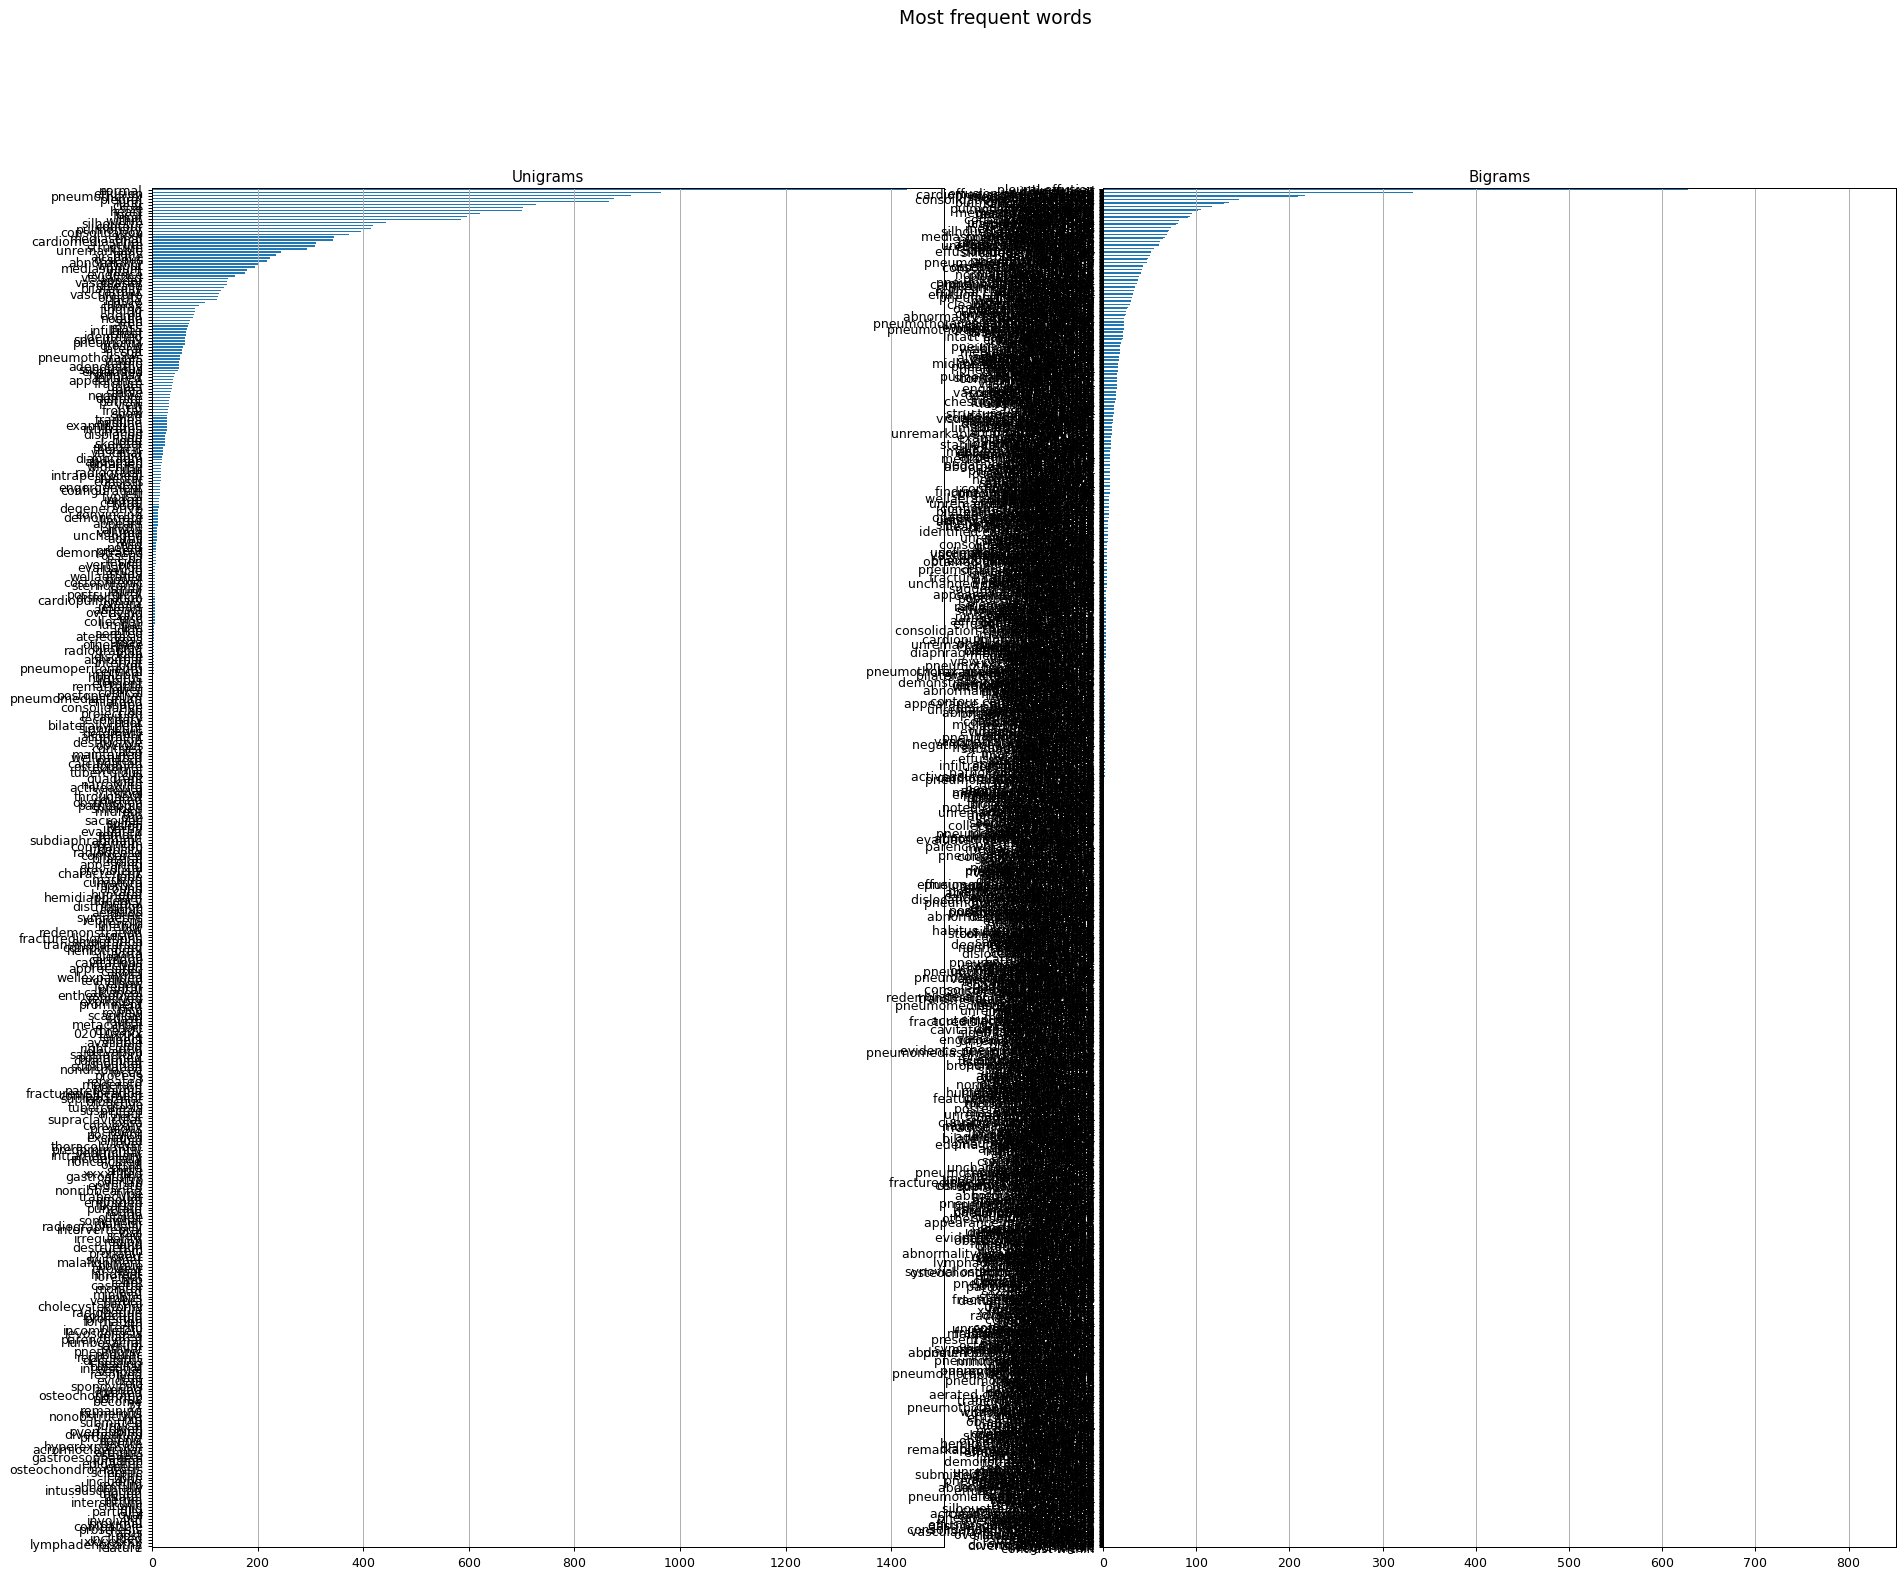

In [31]:
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['figure.dpi'] = 90

y = "normal"
corpus = dtf[dtf["y"] == y]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)

## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[::].sort_values(by="Freq").plot(kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x) )
dtf_bi.set_index("Word").iloc[::].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [32]:
lst_words = ["pneumothorax", "pulmonary", "effusion"]
## count
lst_grams = [len(word.split(" ")) for word in lst_words]
vectorizer = feature_extraction.text.CountVectorizer(
                 vocabulary=lst_words, 
                 ngram_range=(min(lst_grams),max(lst_grams)))
dtf_X = pd.DataFrame(vectorizer.fit_transform(dtf["text_clean"]).todense(), columns=lst_words)
## add the new features as columns
dtf = pd.concat([dtf, dtf_X.set_index(dtf.index)], axis=1)
dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,...,Lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,pneumothorax,pulmonary,effusion
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,...,en,cardiac silhouette mediastinum size within nor...,34,177,6,5.205882,5.666667,1,1,1
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,en,heart size mediastinal contour within normal l...,32,194,5,6.062500,6.400000,1,1,1
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,...,en,heart pulmonary xxxx mediastinum within normal...,38,202,5,5.315789,7.600000,1,1,1
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,en,cardiomediastinal silhouette within normal lim...,38,236,6,6.210526,6.333333,1,0,1
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,...,en,cardiomediastinal silhouette pulmonary vascula...,21,141,5,6.714286,4.200000,1,1,1


In [33]:
dtf['word_count'] = dtf["text"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["text"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,...,Lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,pneumothorax,pulmonary,effusion
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,...,en,cardiac silhouette mediastinum size within nor...,34,177,6,5.205882,5.666667,1,1,1
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,en,heart size mediastinal contour within normal l...,32,194,5,6.062500,6.400000,1,1,1
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,...,en,heart pulmonary xxxx mediastinum within normal...,38,202,5,5.315789,7.600000,1,1,1
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,en,cardiomediastinal silhouette within normal lim...,38,236,6,6.210526,6.333333,1,0,1
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,...,en,cardiomediastinal silhouette pulmonary vascula...,21,141,5,6.714286,4.200000,1,1,1


##### Bivariate distribution; Compare histograms and densities od the samples

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

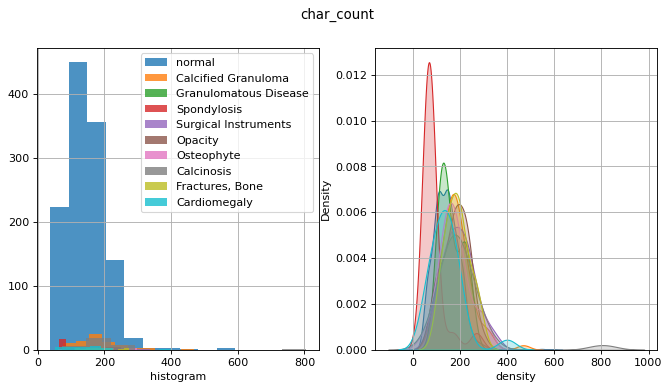

In [34]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 80

x, y = "char_count", "y"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in dtf[y].unique():
    sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(dtf[y].unique())
ax[1].grid(True)
plt.show()

### Sentiment analysis of the data

In [35]:
dtf["sentiment"] = dtf['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
dtf.head()

,y,text,tags,tags_AMINO_ACID,tags_GENE_OR_GENE_PRODUCT,tags_ORGANISM_SUBSTANCE,tags_CELL,tags_CELLULAR_COMPONENT,tags_PATHOLOGICAL_FORMATION,tags_ORGANISM_SUBDIVISION,...,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,pneumothorax,pulmonary,effusion,sentiment
0,normal,The cardiac silhouette and mediastinum size ar...,"[{('cardiac', 'ORGAN'): 1}, {('mediastinum', '...",0,0,0,0,1,1,0,...,cardiac silhouette mediastinum size within nor...,34,177,6,5.205882,5.666667,1,1,1,0.050000
1,normal,Heart size and mediastinal contour are within ...,"[{('Heart', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,heart size mediastinal contour within normal l...,32,194,5,6.062500,6.400000,1,1,1,0.232540
2,normal,"The heart, pulmonary XXXX and mediastinum are ...","[{('heart', 'ORGAN'): 1}, {('pulmonary', 'ORGA...",0,0,0,0,1,0,0,...,heart pulmonary xxxx mediastinum within normal...,38,202,5,5.315789,7.600000,1,1,1,0.150000
3,Calcified Granuloma,The cardiomediastinal silhouette is within nor...,"[{('lungs', 'ORGAN'): 1}, {('focal airspace', ...",0,0,0,0,1,0,0,...,cardiomediastinal silhouette within normal lim...,38,236,6,6.210526,6.333333,1,0,1,0.057143
4,normal,Cardiomediastinal silhouette and pulmonary vas...,"[{('pulmonary vasculature', 'MULTI_TISSUE_STRU...",0,0,0,0,0,0,0,...,cardiomediastinal silhouette pulmonary vascula...,21,141,5,6.714286,4.200000,1,1,1,-0.016667


In [36]:
print(dtf["text"].iloc[2], " --> ", dtf["sentiment"].iloc[2])

The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an interim XXXX cervical spinal fusion partly evaluated.  -->  0.15


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

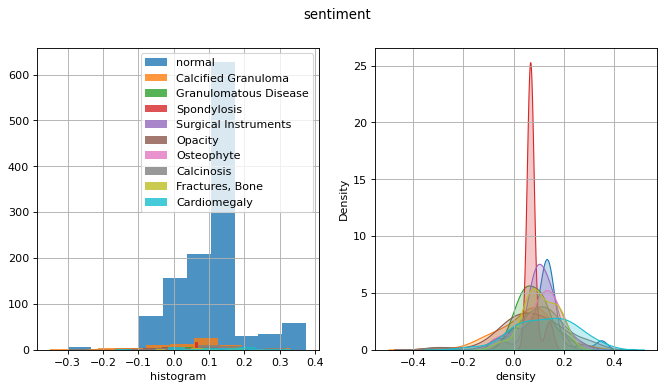

In [37]:
x, y = "sentiment", "y"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in dtf[y].unique():
    sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(dtf[y].unique())
ax[1].grid(True)
plt.show()

##### Most of the labels have a neutral sentiment, except for calcified granuloma and cardiomegally that are skewed on the negative tail, and normal that has a spike on the positive tail.

### Word Vector

In [38]:
nlp = gensim_api.load("glove-wiki-gigaword-300")


your_word = "lungs"
nlp[your_word]

array([-1.8481e-01,  1.1863e-01, -1.6665e-01,  3.5226e-03,  3.9392e-01,
        3.4791e-01,  2.3127e-01,  1.0210e-01, -1.9905e-01, -9.4654e-01,
       -5.8303e-01, -6.8176e-01, -5.4091e-01,  3.8454e-02, -2.8500e-01,
        8.4757e-01, -5.6302e-01, -6.3912e-02, -2.1158e-01,  6.2238e-01,
       -1.6850e-01,  3.1250e-01, -3.4219e-01,  1.7724e-01, -4.4635e-01,
       -1.9539e-01,  4.0748e-01, -2.6759e-01, -9.0850e-02, -5.1311e-01,
       -3.6581e-01,  8.4596e-01, -3.0036e-01,  4.3592e-01,  3.0920e-01,
        9.9434e-02, -1.6415e-01,  1.1831e-02,  1.3877e-01,  7.5933e-01,
       -5.2078e-01,  6.4324e-02, -2.4257e-01, -3.7112e-02,  2.3374e-01,
        1.5880e-01,  1.6659e-01,  5.1749e-01, -2.2648e-01, -1.3326e-01,
        1.3009e-01, -2.9105e-01,  1.4483e-01, -1.5210e-01, -4.8618e-01,
        4.6953e-01,  5.1945e-01, -4.2349e-01,  2.1929e-02,  4.7076e-01,
       -2.3620e-01,  2.4464e-01,  2.2494e-01,  2.2861e-01, -1.7532e-01,
       -1.8645e-02,  5.3344e-01, -9.0447e-02,  5.7687e-03,  5.65

In [39]:
nlp[your_word].shape

(300,)

##### Plot the vectors in a two-dimensional space to see the closest word vectors/words that mostly appear in similar contexts
##### t-distributed Stochastic Neighbor Embedding from Scikit-learn. 
##### t-SNE is a tool to visualize high-dimensional data that converts similarities between data points to joint probabilities.

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(5, 2, 'lungs')

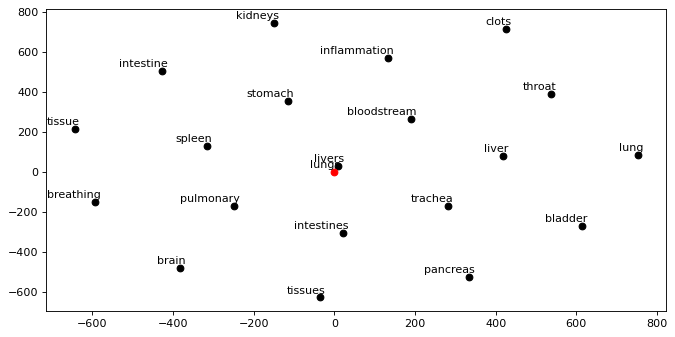

In [40]:
## find closest vectors
labels, X, x, y = [], [], [], []
for t in nlp.most_similar(your_word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])
## reduce dimensions
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])
## plot
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')
## add center
plt.scatter(x=0, y=0, c="red")
plt.annotate(your_word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

### Topic Modelling
##### LDA (Latent Dirichlet Allocation): a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.
##### Let’s see what topics we can extract from opacity

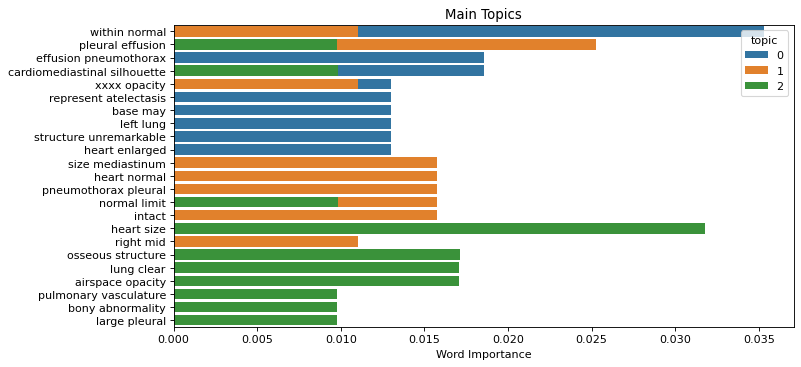

In [41]:
y = "Opacity"
corpus = dtf[dtf["y"]==y]["text_clean"]

## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, 
                                            random_state=123, update_every=1, chunksize=100, passes=10, 
                                            alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

### Dataset split

##### Dataset is split into training set (70%) and test set (30%) in order to evaluate the models performance.

In [42]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## get target
stratify = y 
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [43]:
dtf_train.shape, y_train.shape, dtf_test.shape, y_test.shape

((1009, 28), (1009,), (433, 28), (433,))

### Feature Engineering

##### The process to create features by extracting information from the data
##### Bag-of-Words: term frequency–inverse document frequency (or Tf–Idf) is used with a limit of 10000 words

In [44]:
## Count (classic BoW)
## vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features = 10000, ngram_range=(1,2))

##### Use the vectorizer on the preprocessed corpus of the train set to extract a vocabulary and create the feature matrix.

In [45]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)

X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

X_train.shape

(1009, 2549)

##### The feature matrix X_train has a shape of 1009 (Number of documents in training) x 2583 (Length of vocabulary) and are sparse 

Text(0.5, 1.0, 'Sparse Matrix Sample')

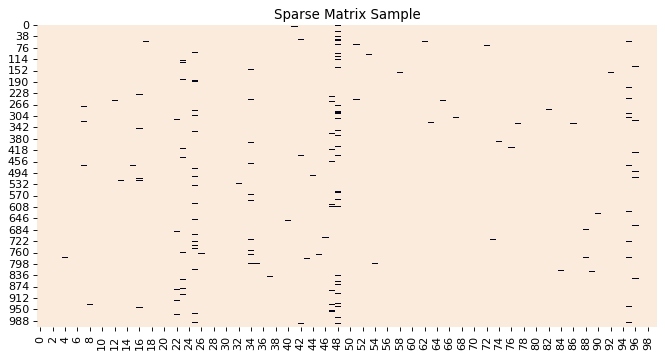

In [46]:
sns.heatmap(X_train.todense()
[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, 
cbar=False).set_title('Sparse Matrix Sample')

##### In order to know the position of a certain word, we can look it up in the vocabulary:

In [47]:
your_word = "effusion"
dic_vocabulary[your_word]

651

### Feature Selection

##### The process of selecting a subset of relevant variables
##### Reduce the matrix dimensionality

In [48]:
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))

    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])

    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]

X_names = dtf_features["feature"].unique().tolist()
X_train.shape

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(1009, 2549)

In [49]:
dtf_features.head()

,feature,score,y
289,calcified,1.0,Calcified Granuloma
291,calcified granuloma,1.0,Calcified Granuloma
896,granuloma,1.0,Calcified Granuloma
904,granuloma left,1.0,Calcified Granuloma
910,granuloma right,1.0,Calcified Granuloma


In [50]:
for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
    print(" ")

# Calcified Granuloma:
  . selected features: 170
  . top features: calcified,calcified granuloma,granuloma,granuloma left,granuloma right,lobe,granuloma within,stable calcified,base,left upper
 
# Calcinosis:
  . selected features: 117
  . top features: lymph,lymph xxxx,calcification,process,hilar lymph,calcified left,left hilar,mediastinal lymph,calcification suggest,granulomatous process
 
# Cardiomegaly:
  . selected features: 121
  . top features: cardiomegaly,mild cardiomegaly,mildly,mildly enlarged,size mildly,enlarged stable,mild,stable mild,enlarged pulmonary,consolidation visible
 
# Fractures, Bone:
  . selected features: 89
  . top features: old,healed,left rib,old left,bilateral rib,fracture,rib,old healed,5th,5th 6th
 
# Granulomatous Disease:
  . selected features: 51
  . top features: disease lung,granulomatous,granulomatous disease,limit prior,prior granulomatous,sequela,granulomatous sequela,sequela noted,prior,noted lung
 
# Opacity:
  . selected features: 195
  . to

##### Refit the vectorizer on the corpus by giving this new set of words as input. That will produce a smaller feature matrix and a shorter vocabulary.

In [51]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
X_train.shape

(1009, 879)

##### The new feature matrix X_train has a shape of is 1009 (Number of documents in training) x 992 (Length of the given vocabulary). 
### Let’s see if the matrix is less sparse

Text(0.5, 1.0, 'Sparse Matrix Sample')

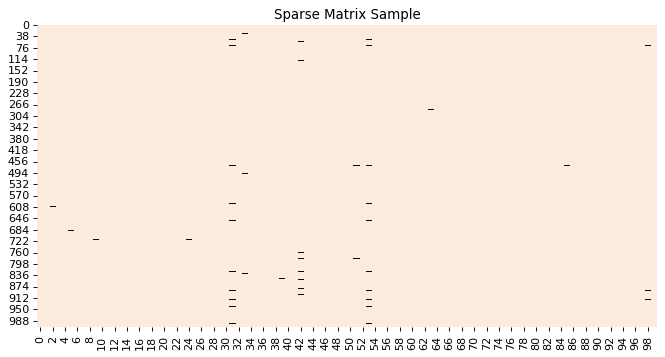

In [52]:
sns.heatmap(X_train.todense()
[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, 
cbar=False).set_title('Sparse Matrix Sample')

### Machine learning model: Naive Bayes

##### Naive Bayes classifier 
##### Build a scikit-learn pipeline: a sequential application of a list of transformations and a final estimator
##### Putting the Tf-Idf vectorizer and the Naive Bayes classifier in a pipeline allows us to transform and predict test data in just one step.

In [53]:
## Naive Bayes classifier 
classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

#### Evaluate the performance of the Bag-of-Words model with 
##### Accuracy
##### Confusion Matrix
##### ROC
##### Precsion
##### Recall

In [54]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
from sklearn import metrics
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr", average="weighted")

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.83
Auc: 0.59
Detail:
                       precision    recall  f1-score   support

  Calcified Granuloma       0.92      0.50      0.65        24
           Calcinosis       0.00      0.00      0.00        14
         Cardiomegaly       0.00      0.00      0.00         4
      Fractures, Bone       0.00      0.00      0.00         4
Granulomatous Disease       0.00      0.00      0.00         8
              Opacity       0.00      0.00      0.00        11
           Osteophyte       0.00      0.00      0.00         6
          Spondylosis       0.00      0.00      0.00         7
 Surgical Instruments       0.00      0.00      0.00         6
               normal       0.83      1.00      0.91       349

             accuracy                           0.83       433
            macro avg       0.18      0.15      0.16       433
         weighted avg       0.72      0.83      0.77       433



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


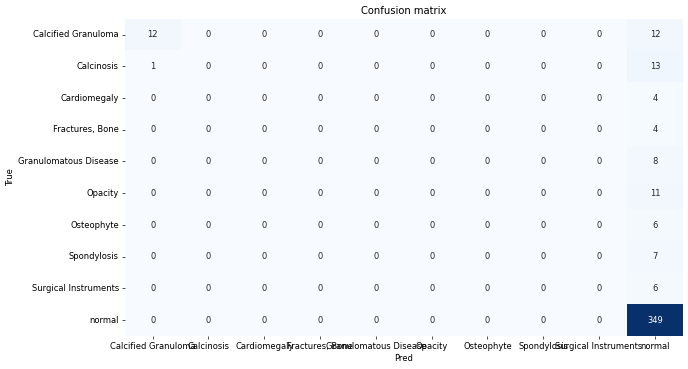

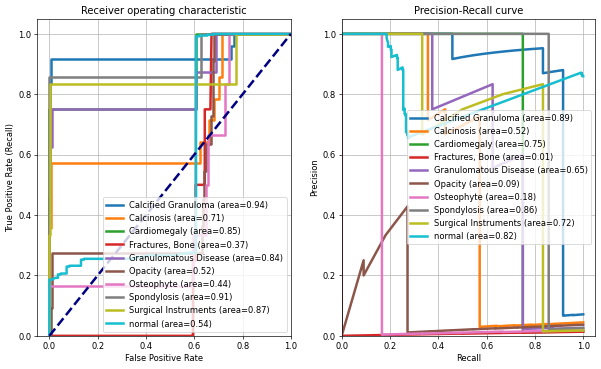

In [55]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 60

## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

##### The BoW model got 88% of the test set right (Accuracy is 0.88), but struggles to recognize Granulomatous Disease, Opacity, Cardiomegaly, and Osteophyte.

##### Try to understand why the model classifies news with a certain category and assess the explainability of these predictions. 
##### The lime package can help us to build an explainer
##### Take a random observation from the test set and see what the model predicts and why

In [56]:
## select observation
i = 7
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: Osteophyte --> Pred: normal | Prob: 0.92


##### That makes sense: the words “No” is pointed the model in the right direction (normal)

### Word emmbeddings

##### Word Embedding is the collective name for feature learning techniques where words from the vocabulary are mapped to vectors of real numbers.
##### Google’s Word2Vec; the first model of this family. Other popular Word Embedding models are Stanford’s GloVe (2014) and Facebook’s FastText (2016)
##### Word2Vec produces a vector space, typically of several hundred dimensions, with each unique word in the corpus such that words that share common contexts in the corpus are located close to one another in the space. 
##### That can be done using 2 different approaches: starting from a single word to predict its context (Skip-gram) or starting from the context to predict a word (Continuous Bag-of-Words).

#### create list of lists of unigrams
#### detect bigrams and trigrams

In [57]:
#nlp = gensim_api.load("word2vec-google-news-300")
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

##### Train NLP (Fit word2vec)
###### When fitting the Word2Vec, you need to specify
###### 1. the target size of the word vectors; I will use 300
###### 2. the window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
###### 3. the training algorithm, I’ll use skip-grams (sg=1) as in general it has better results

##### Select any word from the corpus and transform it into a vector "pneumothorax".

In [58]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=300, window=8, min_count=1, sg=1, epochs=30)

word = "pneumothorax"
nlp.wv[word].shape

(300,)

##### Visualize a word and its context into a smaller dimensional space (2D or 3D) by applying any dimensionality reduction algorithm (i.e. TSNE)isualize a word and its context into a smaller dimensional space (2D or 3D) by applying any dimensionality reduction algorithm (i.e. TSNE).

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


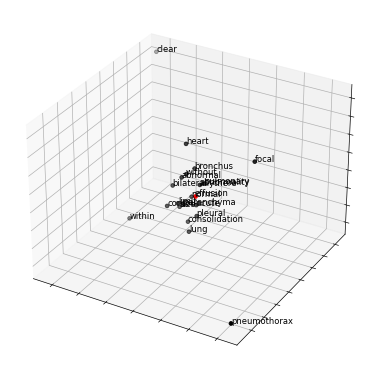

In [59]:
word = "effusion"
fig = plt.figure(figsize=(12, 8))
## word embedding

tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
X = nlp.wv[tot_words]

## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1

## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

##### Feature Engineering by transforming the same preprocessed corpus (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras:

##### First, transform the corpus into padded sequences of word ids to get a feature matrix.
##### Then, create an embedding matrix so that the vector of the word with id N is located at the Nth row.
##### Finally, build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.

In [60]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN", 
                                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen= 15, padding="post", truncating="post")
X_train.shape

(1009, 15)

##### The feature matrix X_train has a shape of 34,265 x 15 (Number of sequences x Sequences max length). Let’s visualize it:

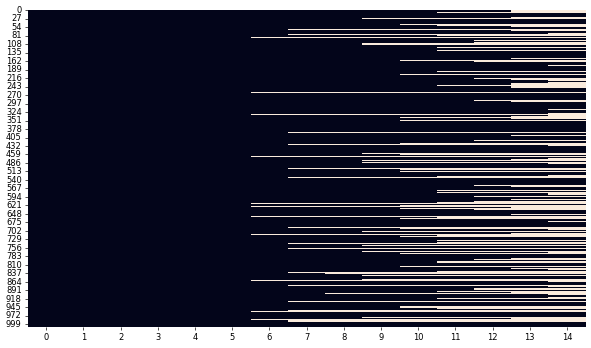

In [61]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

##### Let’s print how a text from the train set has been transformed into a sequence with the padding and the vocabulary.

In [62]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  mediastinal contour normal lung clear pneumothorax large pleural effusion | len: 9
to:  [18 13  2  6  7  4 39  5  3  0  0  0  0  0  0] | len: 15
check:  mediastinal  -- idx in vocabulary --> 18
vocabulary:  {'NaN': 1, 'normal': 2, 'effusion': 3, 'pneumothorax': 4, 'pleural': 5} ... (padding element, 0)


##### Apply the same feature engineering on the test set as well:

In [63]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

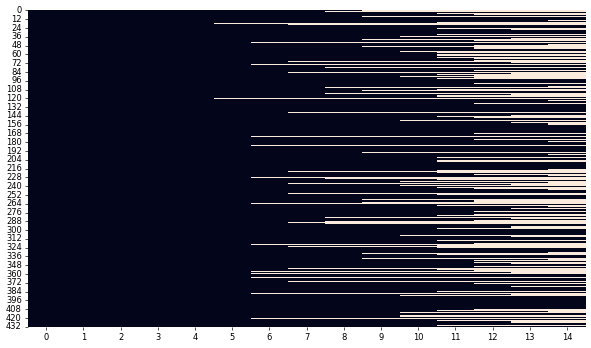

In [64]:
sns.heatmap(X_test ==0, vmin=0, vmax=1, cbar=False)
plt.show()

##### Now that I've got our X_train and X_test, there's a need to create the matrix of embedding (weights with word embedding) that will be used as a weight matrix in the neural network classifier.

In [65]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass
embeddings.shape

(549, 300)

##### That code generates a matrix of shape 530 x 300 (Length of vocabulary extracted from the corpus x Vector size). 
##### It can be navigated by word id, which can be obtained from the vocabulary.

In [66]:
word = "lymph"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

dic[word]: 146 |idx
embeddings[idx]: (300,) |vector


### Deep Learning Model: Attention Bidirectional LSTM

##### Neural Network Structure
##### An Embedding layer that takes the sequences as input and the word vectors as weights, just as described before.
##### A simple Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability). 
#### Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
#### Two final dense layers that will predict the probability of each news category

In [67]:
## code attention layer
def attention_layer(inputs, neurons):                    # input is batch x 15 x 300
    x = layers.Permute((2,1))(inputs)                    # batch x 300 x 15
    x = layers.Dense(neurons, activation="softmax")(x)   # batch x 300 x 15
    x = layers.Permute((2,1), name="attention")(x)  # batch x 15 x 300 'attention' output used for explanability
    x = layers.multiply([inputs, x])                  # batch x 15 x 300 similar as embedding layer output
    return x

## input
x_in = layers.Input(shape=(15,))

## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)

## apply attention
x = attention_layer(x, neurons=15)

## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(10, activation='softmax')(x)

## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2022-04-11 00:19:29.757461: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      164700      ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

###  Train the model and check the performance on a subset of the training set used for validation before testing it on the actual test set.

In [68]:
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}

inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [69]:
%%time
## train 
training = model.fit(x = X_train, y = y_train, batch_size = 256, epochs=15, 
                     shuffle = True, verbose = 1, validation_split = 0.3)

Epoch 1/15
3/3 [==============================] - 12s 1s/step - loss: 2.2859 - accuracy: 0.6558 - val_loss: 2.2540 - val_accuracy: 0.8383
Epoch 2/15
3/3 [==============================] - 0s 130ms/step - loss: 2.2384 - accuracy: 0.8414 - val_loss: 2.2005 - val_accuracy: 0.8383
Epoch 3/15
3/3 [==============================] - 0s 138ms/step - loss: 2.1791 - accuracy: 0.8414 - val_loss: 2.1312 - val_accuracy: 0.8383
Epoch 4/15
3/3 [==============================] - 0s 131ms/step - loss: 2.1032 - accuracy: 0.8414 - val_loss: 2.0399 - val_accuracy: 0.8383
Epoch 5/15
3/3 [==============================] - 0s 132ms/step - loss: 2.0011 - accuracy: 0.8414 - val_loss: 1.9196 - val_accuracy: 0.8383
Epoch 6/15
3/3 [==============================] - 0s 132ms/step - loss: 1.8712 - accuracy: 0.8414 - val_loss: 1.7638 - val_accuracy: 0.8383
Epoch 7/15
3/3 [==============================] - 0s 126ms/step - loss: 1.7029 - accuracy: 0.8414 - val_loss: 1.5671 - val_accuracy: 0.8383
Epoch 8/15
3/3 [======

In [70]:
def plot_training_metrics(training, figsize=(10,5)):
    '''
    Plot loss and accuracy of training.
    '''
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=(10,5))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
         ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.tight_layout()
    plt.show()

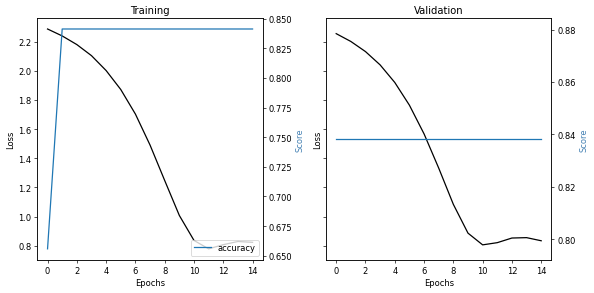

In [71]:
## plot loss and accuracy
plot_training_metrics(training)

In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score 
from sklearn.metrics import plot_confusion_matrix,precision_recall_curve, auc

def evaluate_model_performance(y_test, predicted, predicted_prob, figsize=(15,5)):
    '''
    Evaluates a model performance.
    :parameter
        :param y_test: array
        :param predicted: array
        :param predicted_prob: array
        :param figsize: tuple - plot setting
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = accuracy_score(y_test, predicted)
    auc_ = roc_auc_score(y_test, predicted_prob, multi_class="ovr")
    
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc_,2))
    print("Detail:")
    print(classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

In [73]:
## test
predicted_prob = model.predict(X_test)
predicted = np.array([dic_y_mapping[np.argmax(pred)] for pred in predicted_prob])

## Evaluate model performance
####     improvement on the under-represented class

Accuracy: 0.81
Auc: 0.66
Detail:
                       precision    recall  f1-score   support

  Calcified Granuloma       0.00      0.00      0.00        24
           Calcinosis       0.00      0.00      0.00        14
         Cardiomegaly       0.00      0.00      0.00         4
      Fractures, Bone       0.00      0.00      0.00         4
Granulomatous Disease       0.00      0.00      0.00         8
              Opacity       0.00      0.00      0.00        11
           Osteophyte       0.00      0.00      0.00         6
          Spondylosis       0.00      0.00      0.00         7
 Surgical Instruments       0.00      0.00      0.00         6
               normal       0.81      1.00      0.89       349

             accuracy                           0.81       433
            macro avg       0.08      0.10      0.09       433
         weighted avg       0.65      0.81      0.72       433



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


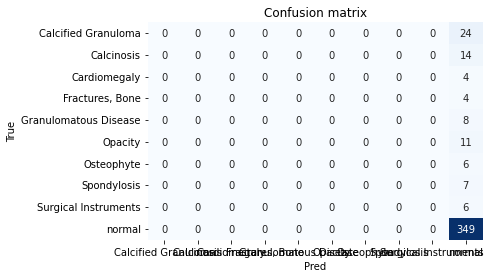

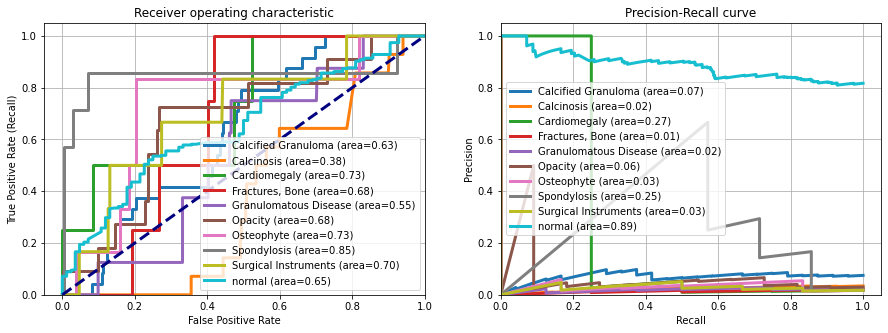

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
evaluate_model_performance(y_test, predicted, predicted_prob)

test sentence:  Increased interstitial opacities non-specific. Question edema or atypical infection?

True: Opacity --> Pred: normal | Prob: 0.84


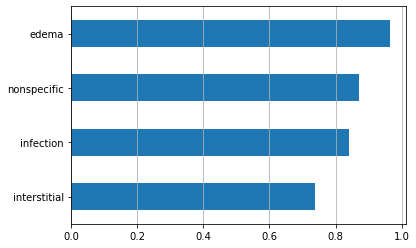

Text with highlighted words


In [75]:
## select observation
#i = sample(range(0, len(dtf_test)),1)[0]
i = 1
txt_instance = dtf_test["text"].iloc[i]
print('test sentence: ',txt_instance)
print()

## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))

## show explanation
top = 4

### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
X_instance = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(lst_corpus), 
                                                maxlen=15, padding="post", truncating="post")

### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()    
# obtain a (_,15,1) vector squeezed and flattened to array of length 15

### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx!= 0]
dic_word_weigth = {word:weights[n] for n, 
                   word in enumerate(lst_corpus[0]) if word in tokenizer.word_index.keys()}

### 4. barplot
%matplotlib inline
import matplotlib.pyplot as plt

if len(dic_word_weigth) > 0:
    dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', columns=["score"])
    
    dtf.sort_values(by="score", ascending=True).tail(top).plot(kind="barh", 
           legend=False).grid(axis='x')
    
    plt.show()
else:
    print("--- No word recognized ---")
    
### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' 
                     + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

#### Nice! In some epochs, the accuracy reached 0.84. 
#### In order to complete the evaluation of the Word Embedding model, let’s predict the test set and compare the same metrics used before (code for metrics is the same as before).

In [76]:
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

(1848, 15) (1848,)


/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [77]:
## train 
training = model.fit(x = X_sm, y = y_sm, batch_size = 256, epochs=15, 
                     shuffle=True, verbose=0, validation_split = 0.3)

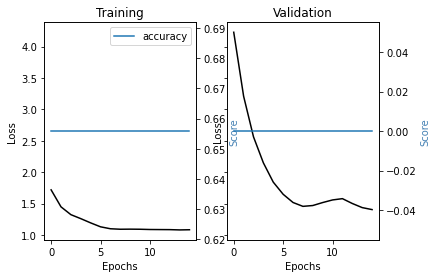

In [78]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [79]:
### test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [80]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

In [81]:
from sklearn import metrics
## Accuracy, Precision, Recall

#accuracy = training.history['accuracy']
#auc = training.history[metric]

accuracy = metrics.accuracy_score(y_test, predicted)
                                  
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr", average="weighted")

print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.81
Auc: 0.74
Detail:
                       precision    recall  f1-score   support

  Calcified Granuloma       0.00      0.00      0.00        24
           Calcinosis       0.00      0.00      0.00        14
         Cardiomegaly       0.00      0.00      0.00         4
      Fractures, Bone       0.00      0.00      0.00         4
Granulomatous Disease       0.00      0.00      0.00         8
              Opacity       0.00      0.00      0.00        11
           Osteophyte       0.00      0.00      0.00         6
          Spondylosis       0.00      0.00      0.00         7
 Surgical Instruments       0.00      0.00      0.00         6
               normal       0.81      1.00      0.89       349

             accuracy                           0.81       433
            macro avg       0.08      0.10      0.09       433
         weighted avg       0.65      0.81      0.72       433



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
